In [ ]:
import os
import sys
import matplotlib.pyplot as plt

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')
import numpy as np

%matplotlib inline

plt.rcParams['figure.dpi'] = 300

: 

## Tools

In [2]:
from scipy import integrate

def get_cci(df):
    def auc(x):
        x = x.groupby(['train_size', 'seed']).agg(np.mean).reset_index()
        cci = integrate.trapz(y=x['loss_scratch']-x['test_loss_normalized'], x=x['loss_scratch'])
        cci /= integrate.trapz(y=x['loss_scratch'], x=x['loss_scratch'])

        return pd.Series({'CCI': cci})
    return df.groupby(['domain', 'method']).apply(auc).reset_index()


def get_calibrated_risk(df):

    def get_last(x):
        return x.iloc[-1]

    def add_scratch_loss(x):
        scratch = x[x['method'] == 'scratch']
        assert scratch.shape[0] == scratch.seed.unique().shape[0]
        scratch = scratch['test_loss_normalized'].mean()
        x['loss_scratch'] = scratch
        return x

    def foo(x):
        # check there is a single blind-guess and gold "methods"
        assert  x[x['method'].isin(['blind-guess'])]['test_loss'].shape[0] == 1, x
        assert  x[x['method'] == 'gold']['test_loss'].shape[0] == 1

        bg = x[x['method'] == 'blind-guess']['test_loss'].iloc[0]
        gold = x[x['method'] == 'gold']['test_loss'].iloc[0]

        print(f'BG={bg:.3f}, GOLD={gold:.3f}: {x["domain"].iloc[0]}')

        x = x[~x['method'].isin(['gold', 'blind-guess'])]
        x['test_loss_normalized'] = (x['test_loss'] - gold)/(bg - gold)

        x = x.groupby(['train_size']).apply(add_scratch_loss).reset_index(drop=True)
        return x

    gb= df.groupby('domain')
    df_scaled = gb.apply(foo).drop('domain', 1).reset_index()

    df_scaled = df_scaled[(df_scaled['domain'] != 'imagenet_cls') | (df_scaled['train_size'] > 1000)]
    return df_scaled

In [3]:
df = pd.read_csv('./assets/ssl-results.csv', index_col=0)

In [4]:
df[df.method == 'blind-guess']

,domain,method,train_size,test_loss,seed
0,depth,blind-guess,-1.0,0.08587,-1.0
98,imgnet_cls,blind-guess,-1.0,99.90000,-1.0
193,normal,blind-guess,-1.0,0.17499,-1.0


In [5]:
df_scaled = get_calibrated_risk(df)
df_scaled.head()

BG=0.086, GOLD=0.028: depth
BG=99.900, GOLD=23.988: imgnet_cls
BG=0.175, GOLD=0.047: normal


,domain,level_1,method,train_size,test_loss,seed,test_loss_normalized,loss_scratch
0,depth,0,barlow_twins,100.0,0.079035,0.0,0.882260,0.994452
1,depth,1,color,100.0,0.083041,0.0,0.951263,0.994452
2,depth,2,color_task,100.0,0.085405,0.0,0.991983,0.994452
3,depth,3,jigsaw,100.0,0.071369,0.0,0.750221,0.994452
4,depth,4,jigsaw_task,100.0,0.082857,0.0,0.948099,0.994452


## $\mathrm{cR}_f-\mathrm{cR}_\mathrm{scratch}$ Curves

In [6]:
method2name = {
    'scratch': 'Scratch',
    'swav': 'SwAV IN',
    'moco': 'MOCOv2 IN',
    'sup': 'ImageNet Supervised',
    'swav_task': 'SwAV Taskonomy',
    'swav_task-freeze': 'SwAV Taskonomy Frozen',
    'moco_task': 'MOCOv2 Taskonomy',
    'color': 'Colorization IN',
    'jigsaw': 'Jigsaw IN',
    'normal': 'Best Transfer (SNE)',
    'reshading': 'Reshading',
    'sup-freeze': 'ImageNet Supervised (frozen)',
    'simclr': 'SimCLR',
    'simsiam': 'SimSiam',
    'barlow_twins': 'Barlow Twins',
    'pirl': 'PIRL',
}

domain2name = {
    'imgnet_cls': "ImageNet Classification",
    'depth': "Depth Estimation",
    'normal': "Surface Normals Estimation",
    'reshading': "Reshaing",
    'cifar100': 'CIFAR-100',
    'eurosat': "EuroSAT",

    'edge_texture': "2D Edges",

}



(-0.10198252326527649, 1.1)

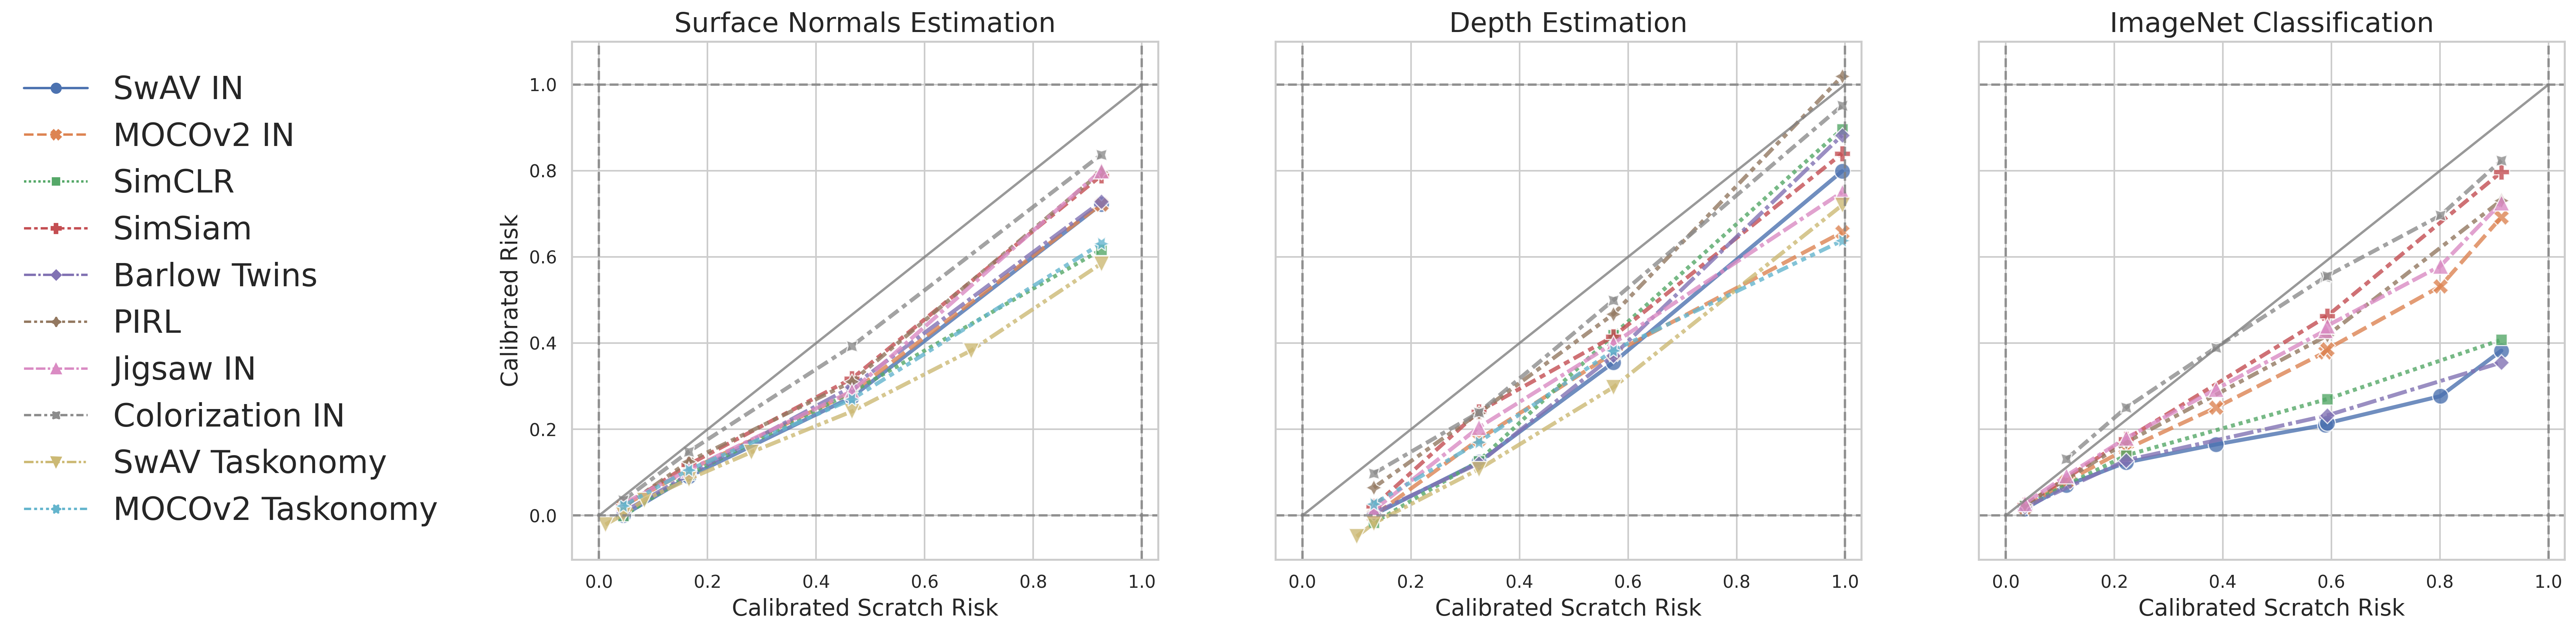

In [7]:
domains = ['normal', 'depth', 'imgnet_cls']

f, axes = plt.subplots(
    1, len(domains),
    figsize=(7.5 * len(domains), 6),
    sharex='col',
    sharey='row',
)

for i, domain in enumerate(domains):
    t = df_scaled.query(
        f'domain == "{domain}"'
    )
    methods = ['swav', 'moco', 'simclr', 'simsiam', 'barlow_twins', 'pirl', 'jigsaw', 'color']
    if domain in ['depth', 'normal']:
        methods += ['swav_task', 'moco_task']
    
    ax = axes[i]
    ax.set_title(domain2name.get(domain), size='xx-large')
    g = sns.lineplot(
        x='loss_scratch',
        y='test_loss_normalized',
        hue='method',
        hue_order=methods,
        style='method',
        style_order=methods,
        data=t,
        ci=None,
        markers=True,
        ax=ax,
        markersize=10,
        linewidth=2.5,
        alpha=0.8,
        legend=(i==0),
    )

    ax.axhline(0., ls='--', color='gray', alpha=0.8)
    ax.axvline(0., ls='--', color='gray', alpha=0.8)

    ax.axvline(1., ls='--', color='gray', alpha=0.8)
    ax.axhline(1., ls='--', color='gray', alpha=0.8)
    x = np.linspace(0, 1, 100)
    ax.plot(x, x, ls='-', color='gray', alpha=0.8, label='')
    ax.set_xlabel('Calibrated Scratch Risk', size='x-large')

    if i == 0:
        handles, labels = ax.get_legend_handles_labels()
        leg = ax.legend(handles, labels, loc='center right', bbox_to_anchor=(-.18, 0.5, 0.0, 0.0), fontsize=20, frameon=False)
        for label in leg.texts:
            label.set_text(method2name[label.get_text()])


    ax.set_xlim(right=1.03)
    g.axes.set_ylabel('Calibrated Risk', size='x-large')

axes[0].set_ylim(top=1.1)

## $\mathrm{cR}_f-n$ and $\mathrm{cR}_f-\mathrm{cR}_\mathrm{scratch}$ Curves with CCI

In [8]:
df_cci = get_cci(df_scaled)
df_cci.head()

<ipython-input-2-914582969852>:7: RuntimeWarning: invalid value encountered in double_scalars
  cci /= integrate.trapz(y=x['loss_scratch'], x=x['loss_scratch'])


,domain,method,CCI
0,depth,barlow_twins,0.305263
1,depth,color,0.114999
2,depth,color_task,0.038894
3,depth,jigsaw,0.303948
4,depth,jigsaw_task,0.027338


<Figure size 6300x4200 with 0 Axes>

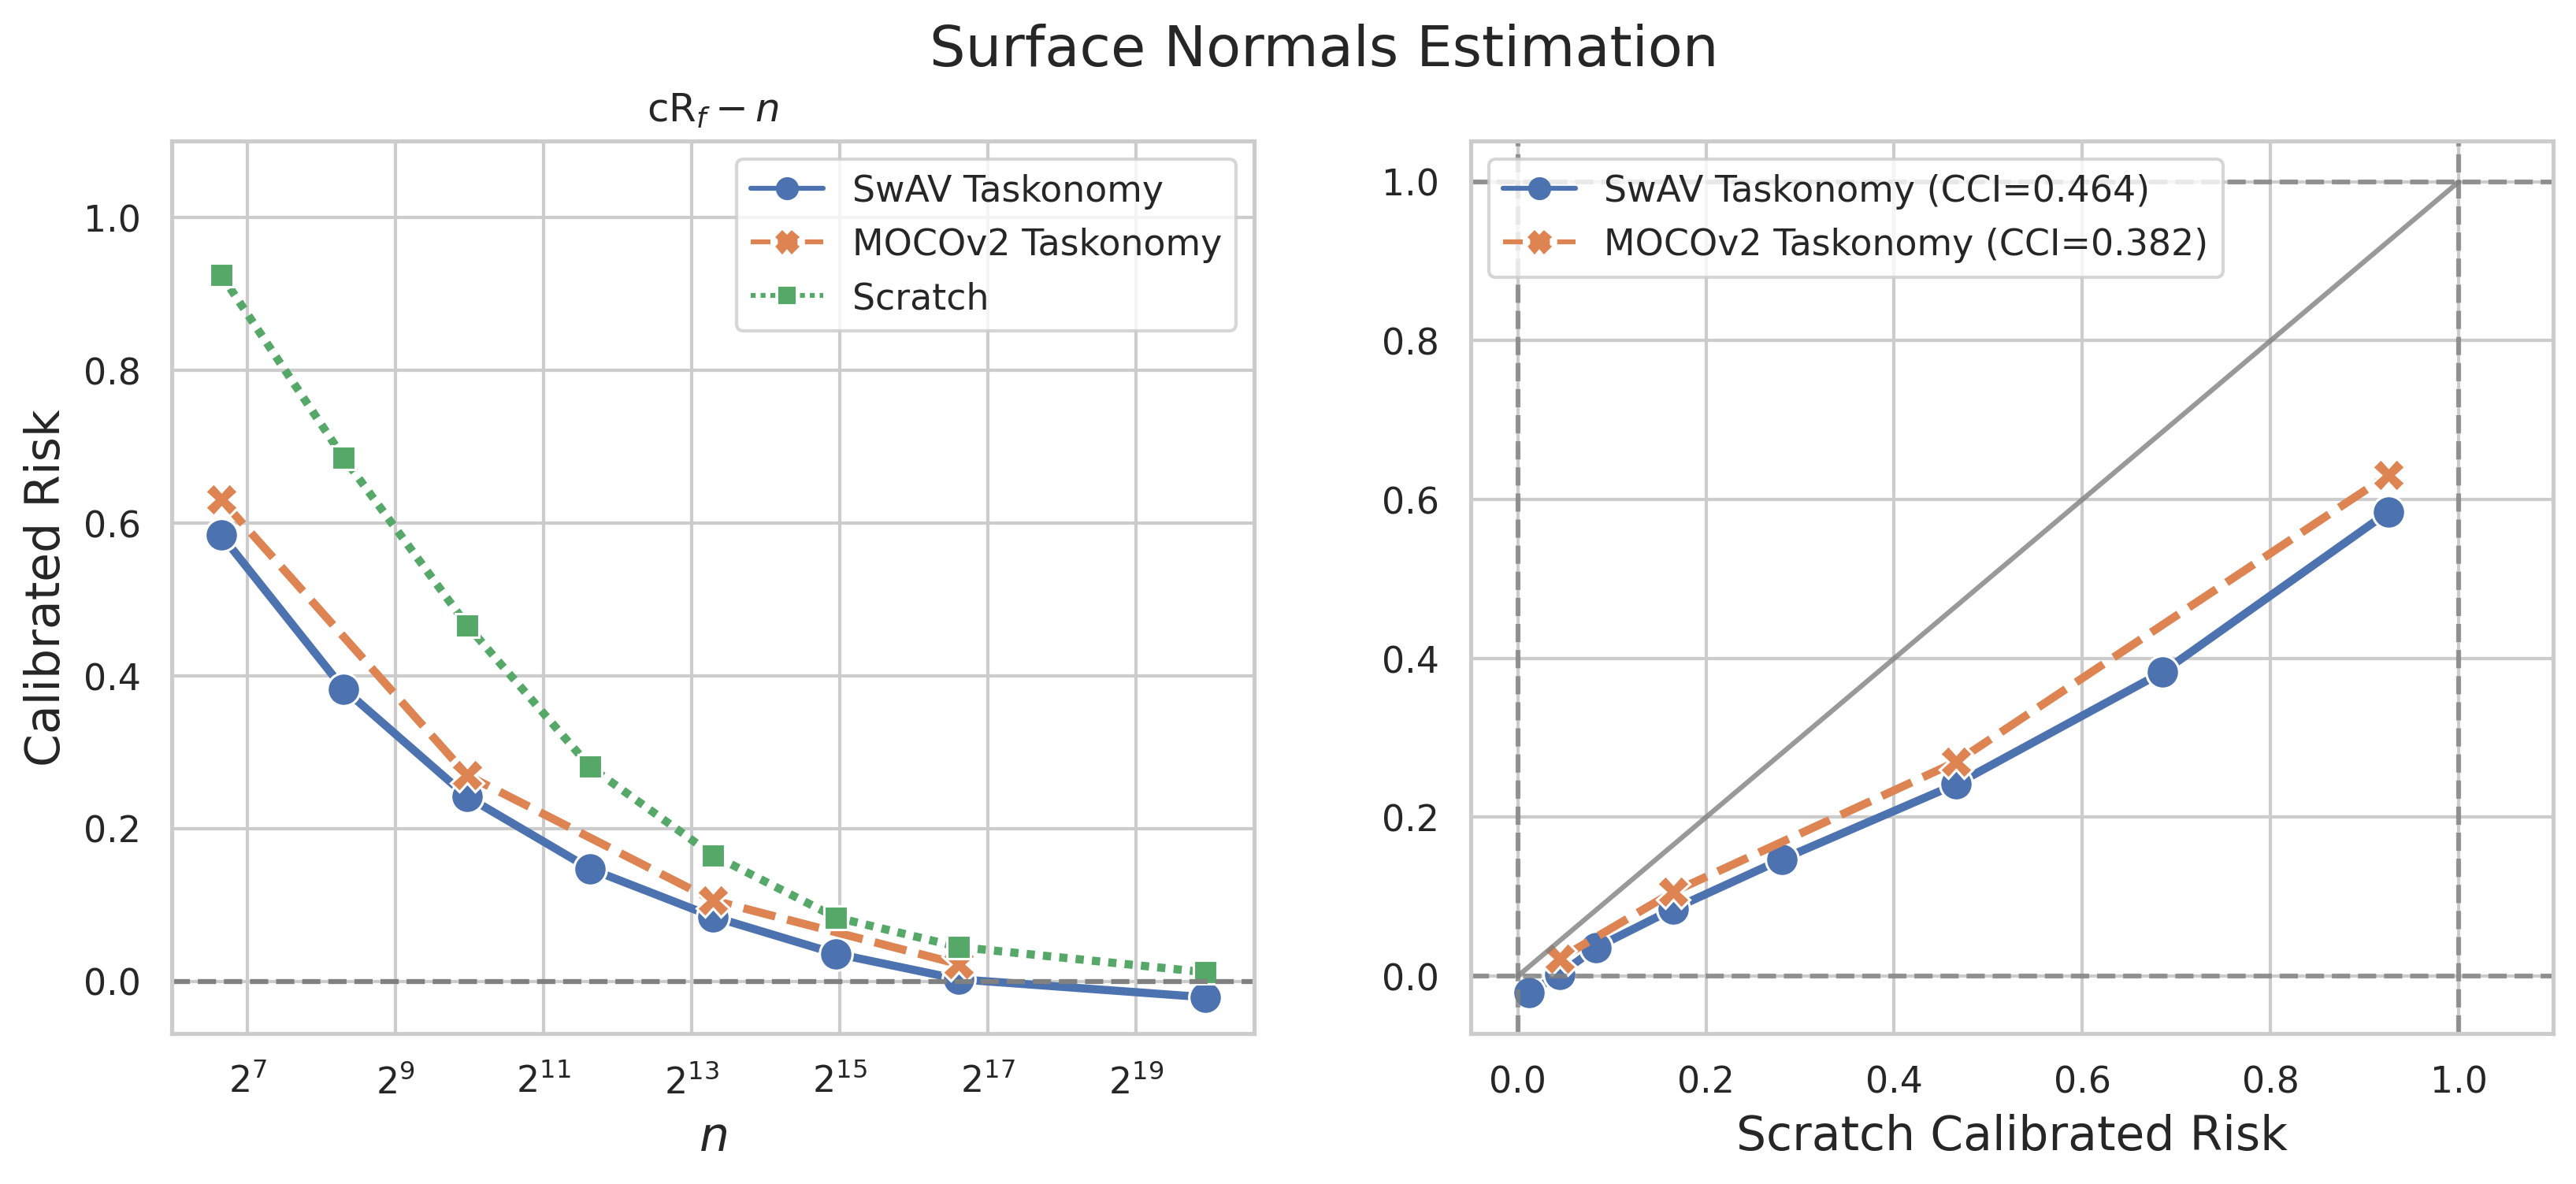

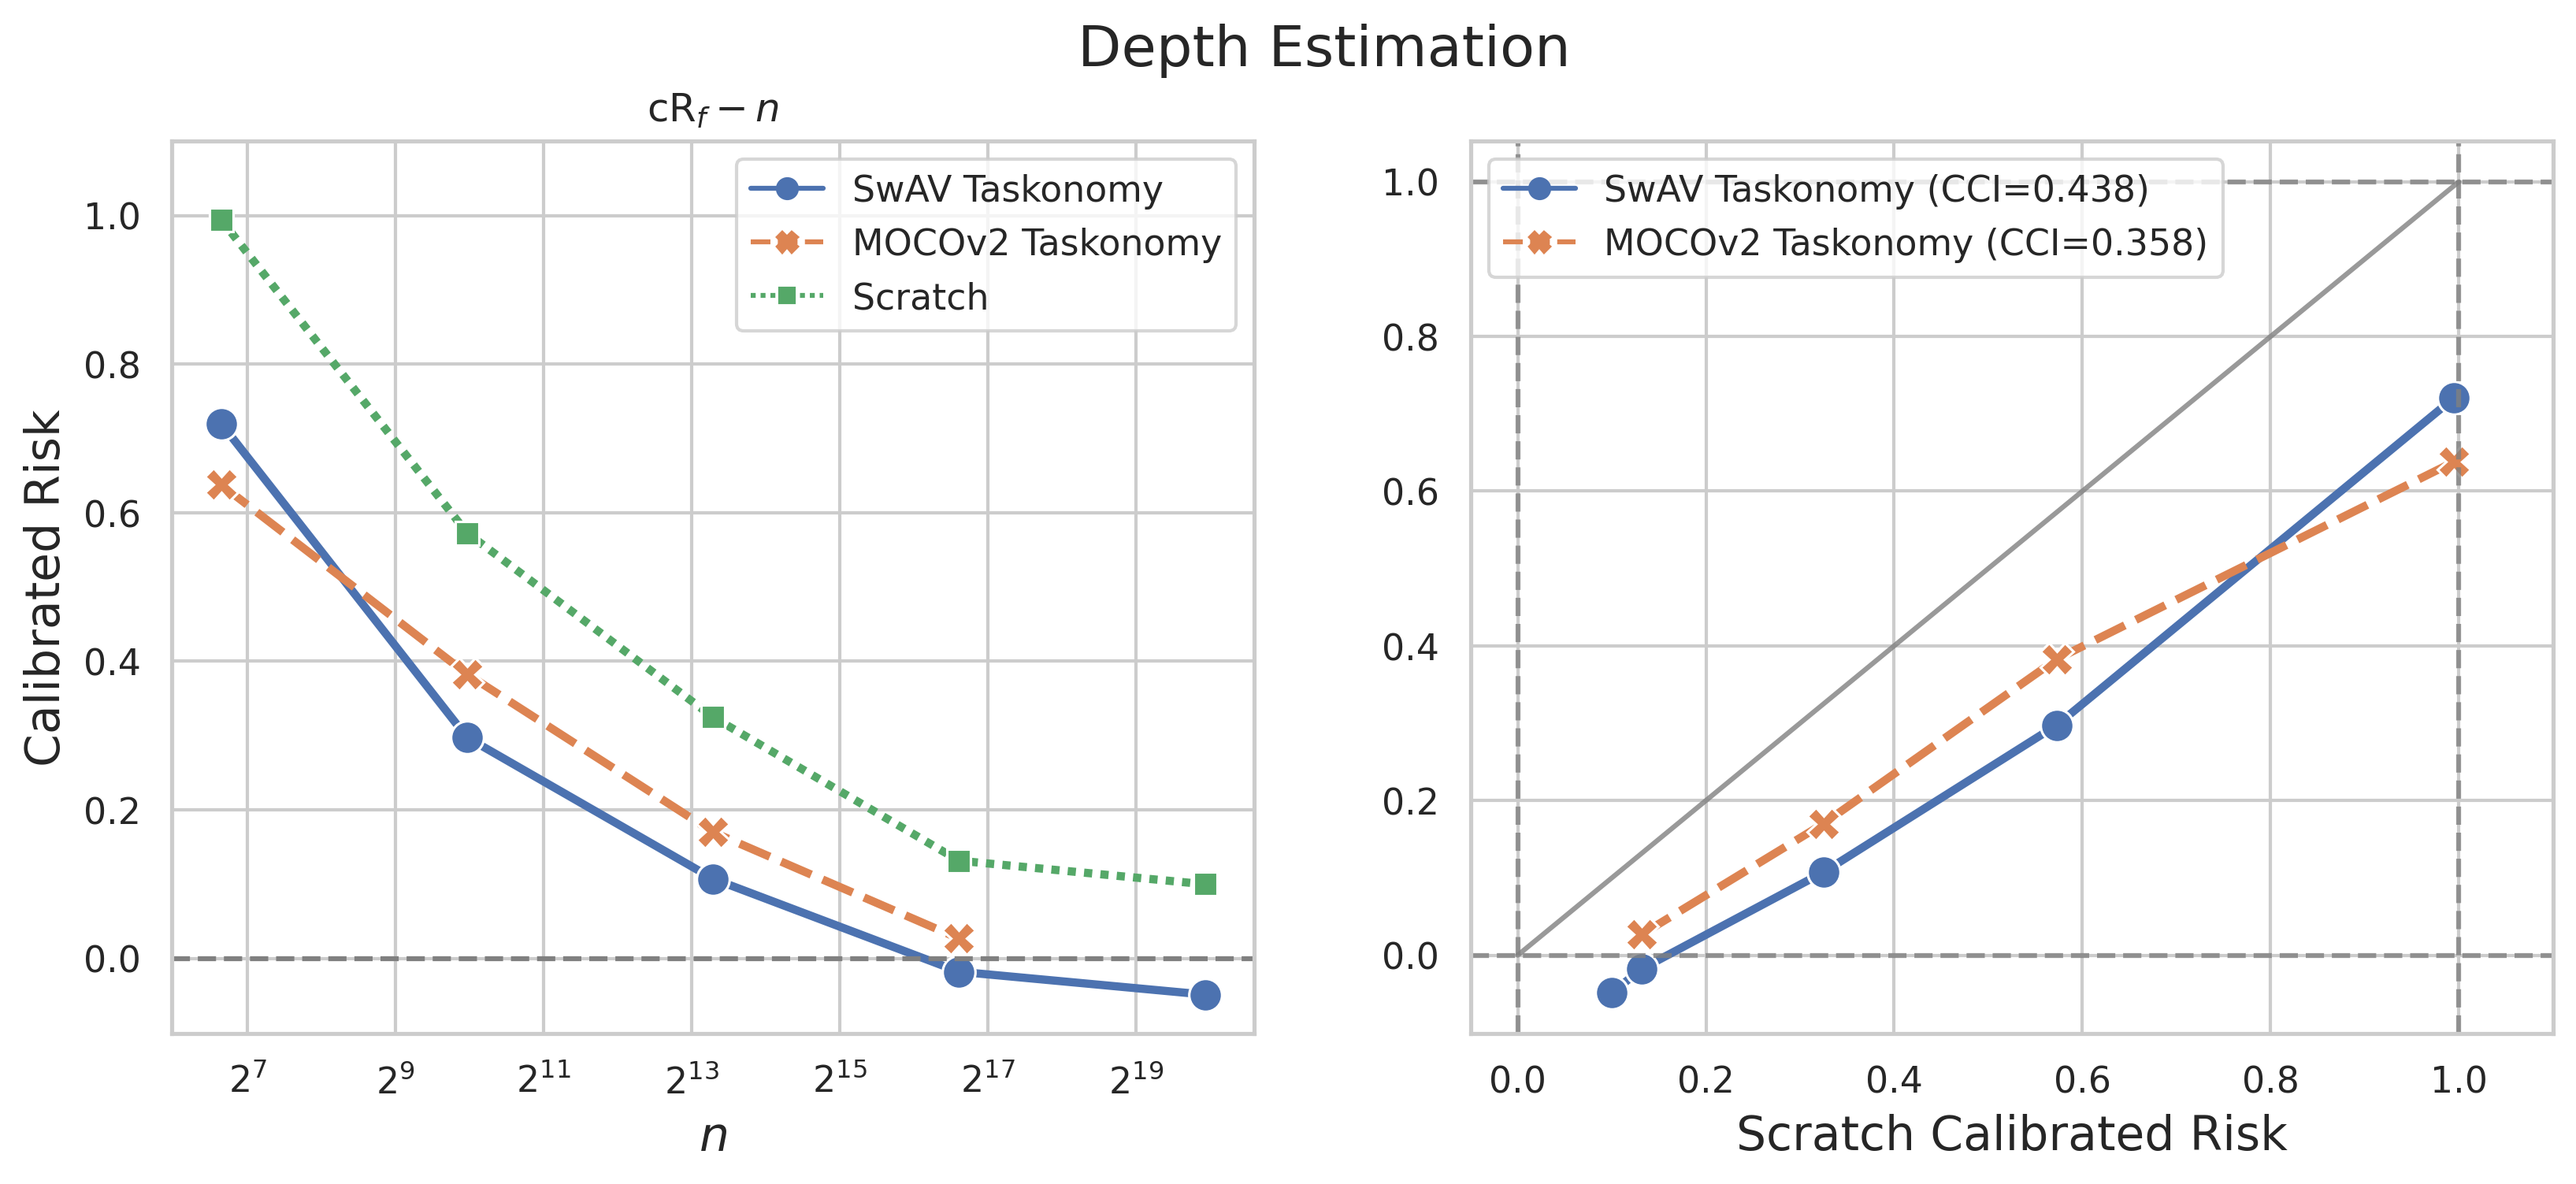

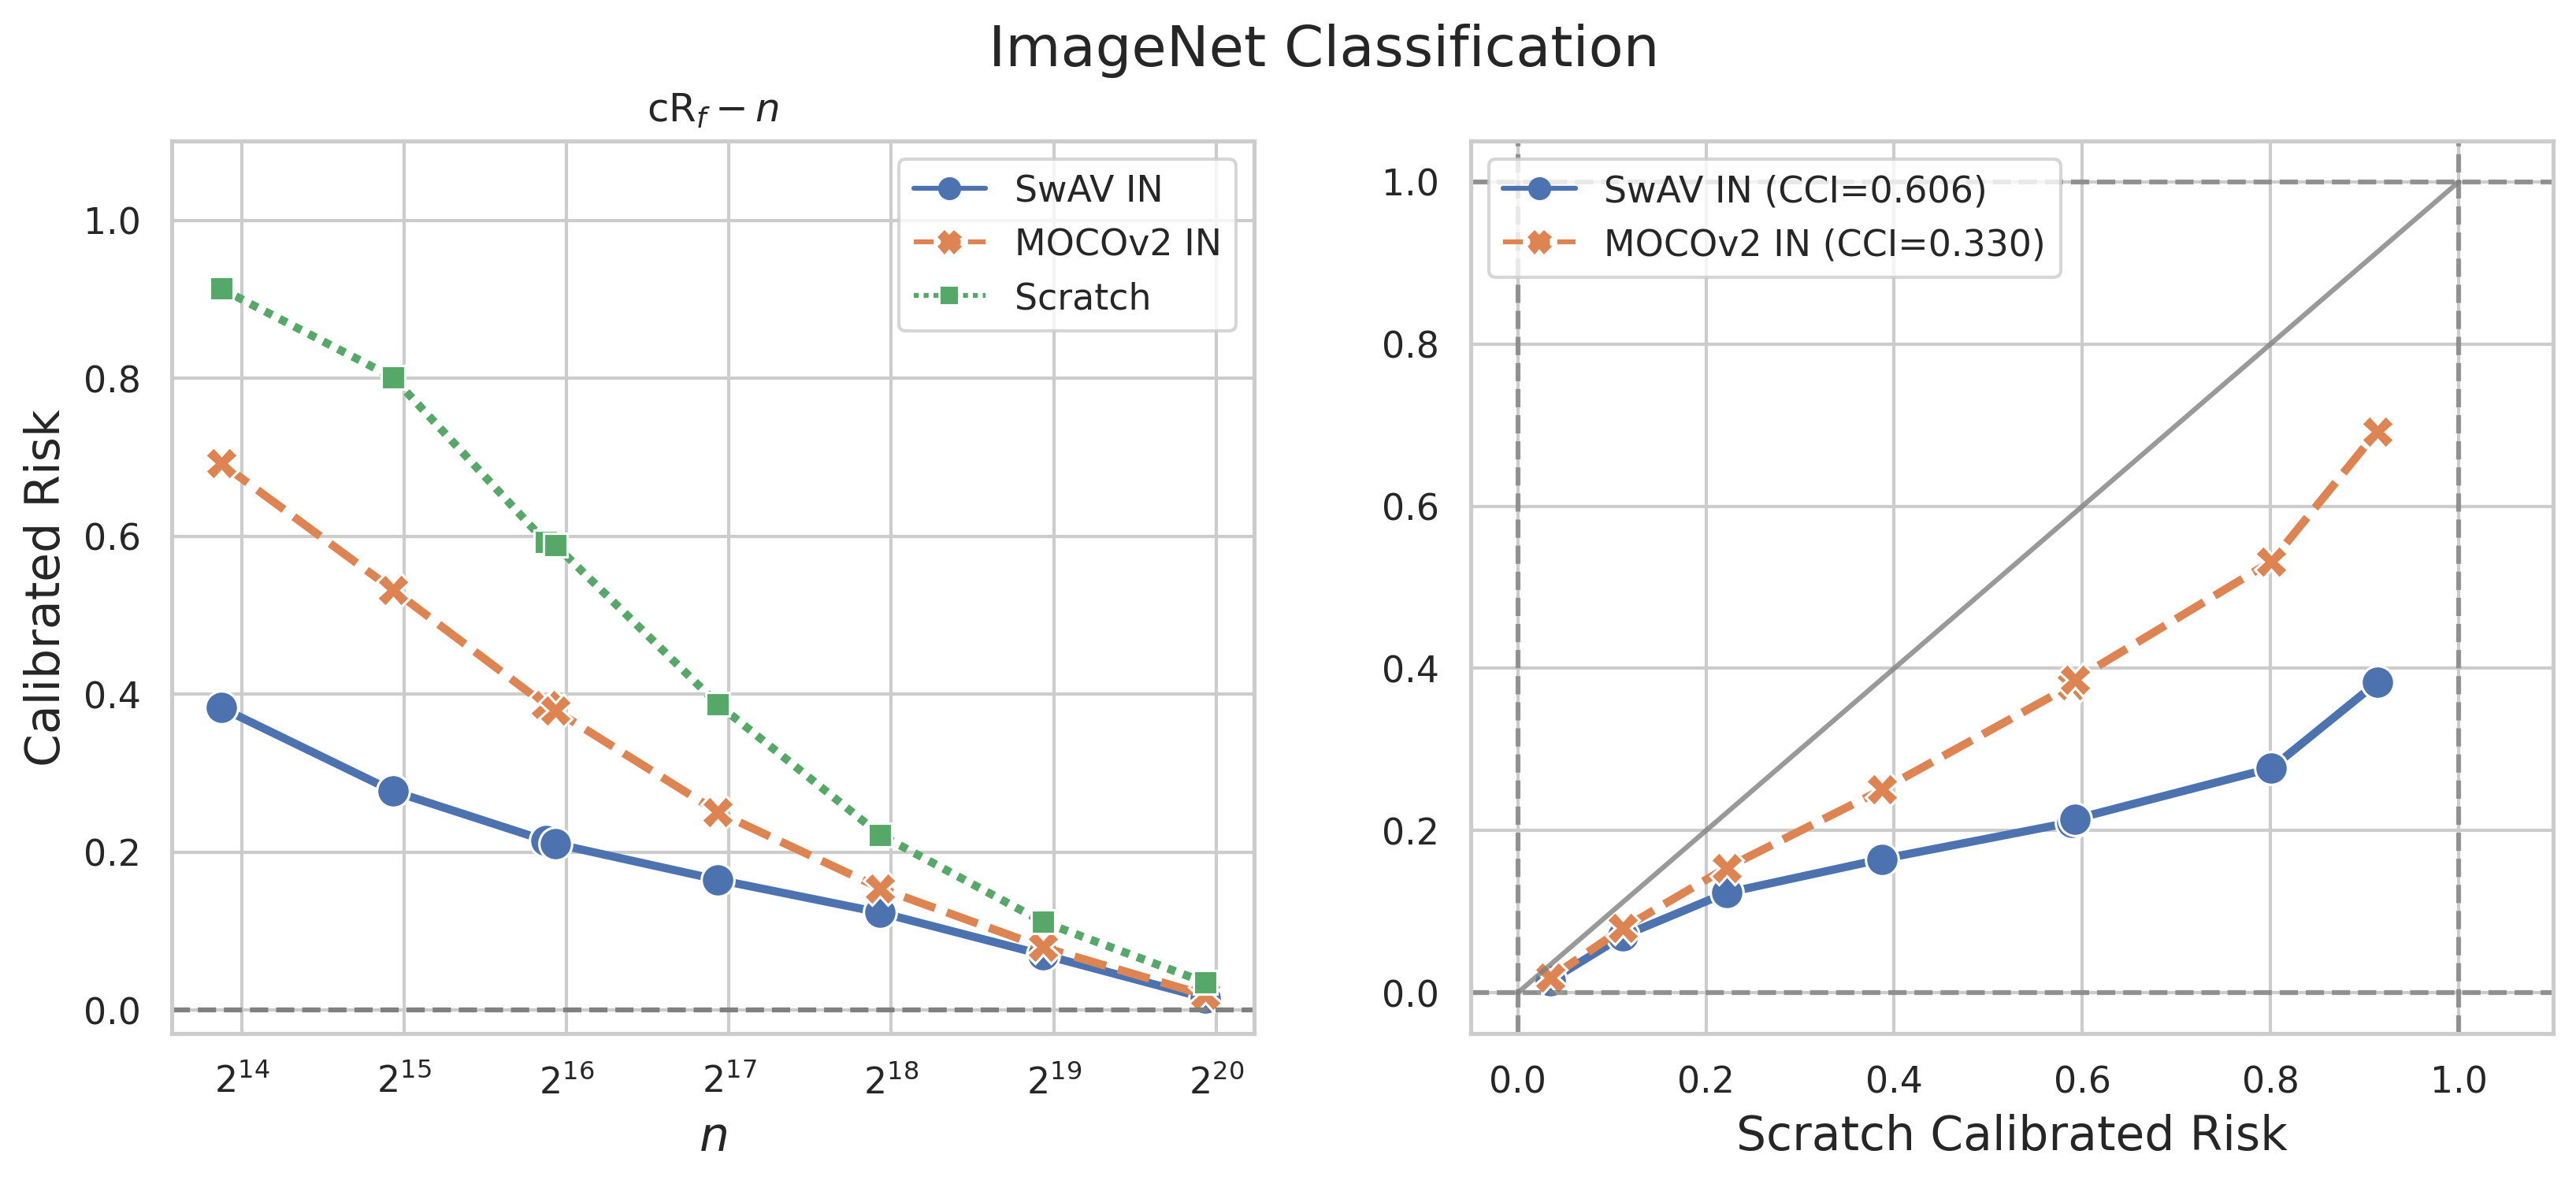

In [9]:
import matplotlib.gridspec as gridspec

domains = ['normal', 'depth', 'imgnet_cls']

fig = plt.figure(
    figsize=(7 * len(domains), 14),
)
outer = gridspec.GridSpec(
    2, 2, 
    wspace=0.2, hspace=0.4,
)

for i, domain in enumerate(domains):
    fig, axes = plt.subplots(
        1, 2,
        figsize=(13, 5),
    )

    t = df_scaled.query(
        f'domain == "{domain}"'
    )
    methods = []
    if domain in ['normal', 'depth']:
        methods += ['swav_task', 'moco_task']
    else:
        methods += ['swav', 'moco']
    methods += ['scratch']

    ax = axes[0]

    plt.suptitle(domain2name.get(domain), size='xx-large')
    g = sns.lineplot(
        x='train_size',
        y='test_loss_normalized',
        hue='method',
        hue_order=methods,
        style='method',
        style_order=methods,
        data=t,
        ci=None,
        markers=True,
        ax=ax,
        markersize=10,
        linewidth=2.5,
    )
    leg = ax.legend()
    for label in leg.texts:
        label.set_text(method2name[label.get_text()])

    ax.set_title('$\mathrm{cR}_f-n$')
    ax.axhline(0., ls='--', color='gray')
    ax.set_xscale('log', base=2)
    ax.set_ylabel('Calibrated Risk', size='x-large')
    ax.set_ylim(top=1.1)
    ax.set_xlabel('$n$', size='x-large')

    ax = axes[1]
    methods.remove('scratch')
    g = sns.lineplot(
        x='loss_scratch',
        y='test_loss_normalized',
        hue='method',
        hue_order=methods,
        style='method',
        style_order=methods,
        data=t,
        ci=None,
        markers=True,
        ax=ax,
        markersize=10,
        linewidth=2.5,
    )
    leg = ax.legend()
    for label in leg.texts:
        label.set_text(method2name[label.get_text()])
    
    ax.axhline(0., ls='--', color='gray', alpha=0.8)
    ax.axvline(0., ls='--', color='gray', alpha=0.8)

    ax.axvline(1., ls='--', color='gray', alpha=0.8)
    ax.axhline(1., ls='--', color='gray', alpha=0.8)
    x = np.linspace(0, 1, 100)
    ax.plot(x, x, ls='-', color='gray', alpha=0.8, label='')
    
    ax.set_xlim(right=1.1)
    ax.set_xlabel('Scratch Calibrated Risk', size='x-large')

    x_axis = ax.get_yaxis()
    x_axis.get_label().set_visible(False)

    leg = ax.legend(loc='upper left')
    for label in leg.texts:
        method = label.get_text()
        cci = df_cci.query(f'method == "{method}" & domain == "{domain}"')['CCI'].values[0]
        label.set_text(method2name[label.get_text()] + f' (CCI={cci:.3f})')


    plt.show()